# AutoencoderKL

This demo is a toy example of how to use MONAI's AutoencoderKL. In particular, it uses
the Autoencoder with a Kullback-Leibler regularisation as implemented by Rombach et. al [1].

[1] Rombach et. al - ["High-Resolution Image Synthesis with Latent Diffusion Models"](https://arxiv.org/pdf/2112.10752.pdf)



This tutorial was based on:

[Registration Mednist](https://github.com/Project-MONAI/tutorials/blob/main/2d_registration/registration_mednist.ipynb)

[Mednist Tutorial](https://github.com/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb)




In [1]:
# TODO: Add buttom with "Open with Colab"

## Set up environment using Colab

In [2]:
!pip install -q "monai-weekly[tqdm]==1.1.dev2239"
!pip install -q matplotlib
!pip install -q einops
%matplotlib inline


[notice] A new release of pip available: 22.2.1 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 22.3
[notice] To update, run: pip install --upgrade pip


## Setup imports

In [3]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from tqdm import tqdm

from generative.networks.nets import AutoencoderKL

print_config()

MONAI version: 1.1.dev2239
Numpy version: 1.23.3
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 13b24fa92b9d98bd0dc6d5cdcb52504fd09e297b
MONAI __file__: /media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1+cu113
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For deta

In [4]:
# for reproducibility purposes set a seed
set_determinism(42)

## Setup a data directory and download dataset

Specify a `MONAI_DATA_DIRECTORY` variable, where the data will be downloaded. If not
specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmprx4prevn


### Download the training set

In [6]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)

MedNIST.tar.gz: 59.0MB [00:03, 16.6MB/s]                                                                                                                                                                                        

2022-11-08 10:38:50,344 - INFO - Downloaded: /tmp/tmprx4prevn/MedNIST.tar.gz


2022-11-08 10:38:50,415 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-08 10:38:50,415 - INFO - Writing into directory: /tmp/tmprx4prevn.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:14<00:00, 3330.78it/s]


### Visualise examples from the training set

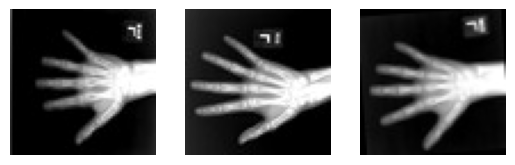

In [7]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

### Download the validation set

In [8]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4)

2022-11-08 10:39:09,457 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-08 10:39:09,458 - INFO - File exists: /tmp/tmprx4prevn/MedNIST.tar.gz, skipped downloading.
2022-11-08 10:39:09,458 - INFO - Non-empty folder exists in /tmp/tmprx4prevn/MedNIST, skipped extracting.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5895/5895 [00:01<00:00, 3454.67it/s]


## Define the network

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
model = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=64,
    latent_channels=8,
    ch_mult=(1, 2, 3),
    num_res_blocks=1,
    norm_num_groups=16,
    attention_levels=(False, False, True),
)
model.to(device)

Using cuda


AutoencoderKL(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Convolution(
        (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ResBlock(
        (norm1): GroupNorm(16, 64, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(16, 64, eps=1e-06, affine=True)
        (conv2): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (nin_shortcut): Identity()
      )
      (2): Downsample(
        (conv): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (3): ResBlock(
        (norm1): GroupNorm(16, 64, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(16, 128, eps=1e-06, affi

## Model Training

In [10]:
kl_weight = 1e-6
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
n_epochs = 50
val_interval = 10
epoch_loss_list = []
val_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)
        reconstruction, z_mu, z_sigma = model(images)

        l1_loss = F.l1_loss(reconstruction.float(), images.float())

        kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
        kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]

        # TODO: Add adversarial component
        # TODO: Add perceptual loss

        loss = l1_loss + kl_weight * kl_loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        progress_bar.set_postfix(
            {
                "loss": epoch_loss / (step + 1),
            }
        )
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                optimizer.zero_grad(set_to_none=True)
                reconstruction, z_mu, z_sigma = model(images)
                # get the first sammple from the first validation batch for visualisation
                # purposes
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                l1_loss = F.l1_loss(reconstruction.float(), images.float())

                kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
                kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]

                # TODO: Add adversarial component
                # TODO: Add perceptual loss

                loss = l1_loss + kl_weight * kl_loss
                val_loss += loss.item()

        val_loss /= val_step
        val_epoch_loss_list.append(val_loss)

        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()


Epoch 9: 100%|█████████| 125/125 [00:29<00:00,  4.20it/s, loss=0.0397]


epoch 10 val loss: 0.0415


Epoch 19: 100%|████████| 125/125 [00:30<00:00,  4.13it/s, loss=0.0325]


epoch 20 val loss: 0.0342


Epoch 29: 100%|████████| 125/125 [00:30<00:00,  4.16it/s, loss=0.0287]


epoch 30 val loss: 0.0305


Epoch 39: 100%|████████| 125/125 [00:30<00:00,  4.16it/s, loss=0.0265]


epoch 40 val loss: 0.0283


Epoch 49: 100%|████████| 125/125 [00:30<00:00,  4.17it/s, loss=0.0249]


epoch 50 val loss: 0.0264


## Evaluate the training
### Visualise the loss

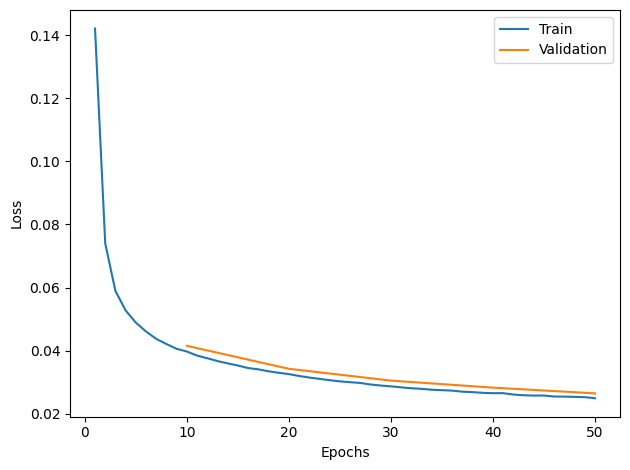

In [11]:
plt.figure()
val_samples = np.linspace(val_interval, n_epochs, int(n_epochs / val_interval))
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, label="Train")
plt.plot(val_samples, val_epoch_loss_list, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

### Visualise some reconstruction images

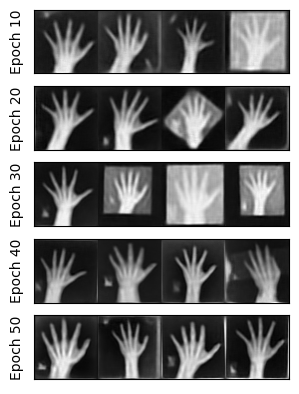

In [12]:
# Plot every evaluation as a new line and example as columns
fig, ax = plt.subplots(nrows=len(val_samples), ncols=1, sharey=True)
for image_n in range(len(val_samples)):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * n_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")